# CATastrophe Model Evaluation

This notebook evaluates the accuracy of the CATastrophe vulnerability detection model using test datasets.

In [1]:
import json
import torch
import numpy as np
from huggingface_hub import hf_hub_download
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load test data
with open('tests/test_data/safe_c_commits.json', 'r') as f:
    safe_commits = json.load(f)

with open('tests/test_data/vulnerable_c_commits.json', 'r') as f:
    vulnerable_commits = json.load(f)

print(f"Loaded {len(safe_commits)} safe commits")
print(f"Loaded {len(vulnerable_commits)} vulnerable commits")

Loaded 10 safe commits
Loaded 10 vulnerable commits


In [3]:
# Download model and vectorizer from Hugging Face
model_repo = "ewhk9887/CATastrophe"

print("Downloading model from Hugging Face...")
model_path = hf_hub_download(repo_id=model_repo, filename="catastrophe_model.pth")
vectorizer_path = hf_hub_download(repo_id=model_repo, filename="vectorizer.pkl")

print("Model downloaded successfully!")

Model downloaded successfully!


In [4]:
# Load vectorizer
with open(vectorizer_path, 'rb') as f:
    vectorizer = pickle.load(f)

# Get feature dimension
feature_dim = vectorizer.get_feature_names_out().shape[0]
print(f"Feature dimension: {feature_dim}")

Feature dimension: 2000


In [5]:
# Define model architecture (must match the trained model)
class EnhancedAutoencoder(torch.nn.Module):
    def __init__(self, input_dim):
        super(EnhancedAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(1024, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(512, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(256, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU()
        )
        
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(256, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(512, 1024),
            torch.nn.BatchNorm1d(1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            
            torch.nn.Linear(1024, input_dim),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = EnhancedAutoencoder(feature_dim)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

print("Model loaded successfully!")

Using device: cpu
Model loaded successfully!


In [7]:
# Function to predict vulnerability
def predict_vulnerability(message, func, threshold=0.5):
    # Combine message and function
    text = f"{message} {func}"
    
    # Vectorize
    features = vectorizer.transform([text]).toarray()
    features_tensor = torch.tensor(features, dtype=torch.float32).to(device)
    
    # Get reconstruction
    with torch.no_grad():
        reconstruction = model(features_tensor)
        
    # Calculate reconstruction error
    mse = torch.nn.functional.mse_loss(reconstruction, features_tensor, reduction='none')
    reconstruction_error = mse.mean(dim=1).item()
    
    # Higher error indicates vulnerability
    is_vulnerable = reconstruction_error > threshold
    
    return is_vulnerable, reconstruction_error

In [8]:
# Evaluate on test data
y_true = []
y_pred = []
y_scores = []

# Test safe commits (label = 0)
for commit in safe_commits:
    is_vuln, score = predict_vulnerability(commit['message'], commit['func'])
    y_true.append(0)
    y_pred.append(1 if is_vuln else 0)
    y_scores.append(score)

# Test vulnerable commits (label = 1)
for commit in vulnerable_commits:
    is_vuln, score = predict_vulnerability(commit['message'], commit['func'])
    y_true.append(1)
    y_pred.append(1 if is_vuln else 0)
    y_scores.append(score)

print("Evaluation complete!")

Evaluation complete!


In [9]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy:.2%}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Safe', 'Vulnerable']))


Accuracy: 50.00%

Classification Report:
              precision    recall  f1-score   support

        Safe       0.50      1.00      0.67        10
  Vulnerable       0.00      0.00      0.00        10

    accuracy                           0.50        20
   macro avg       0.25      0.50      0.33        20
weighted avg       0.25      0.50      0.33        20



/home/max/max-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/max/max-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/max/max-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


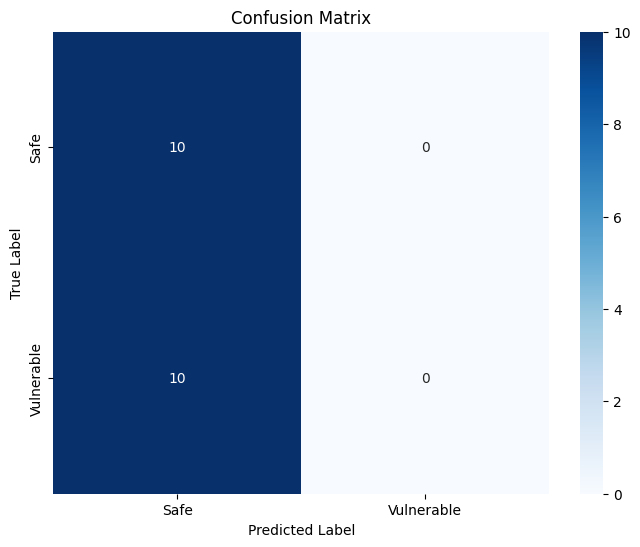

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Safe', 'Vulnerable'], 
            yticklabels=['Safe', 'Vulnerable'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

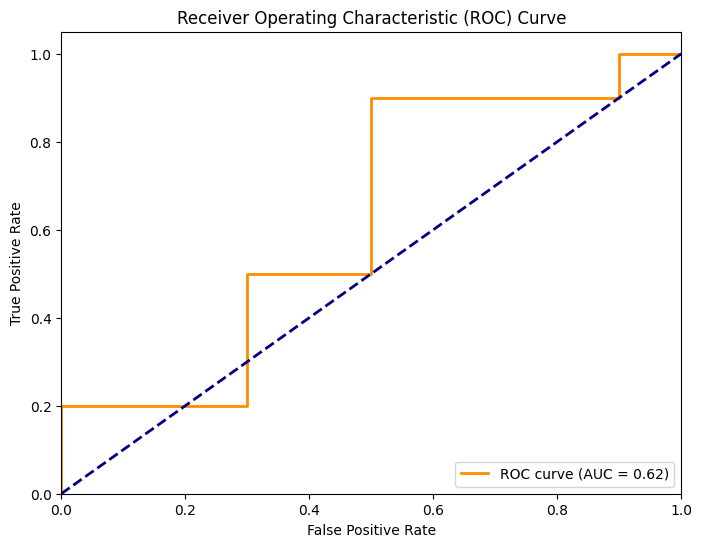

In [11]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

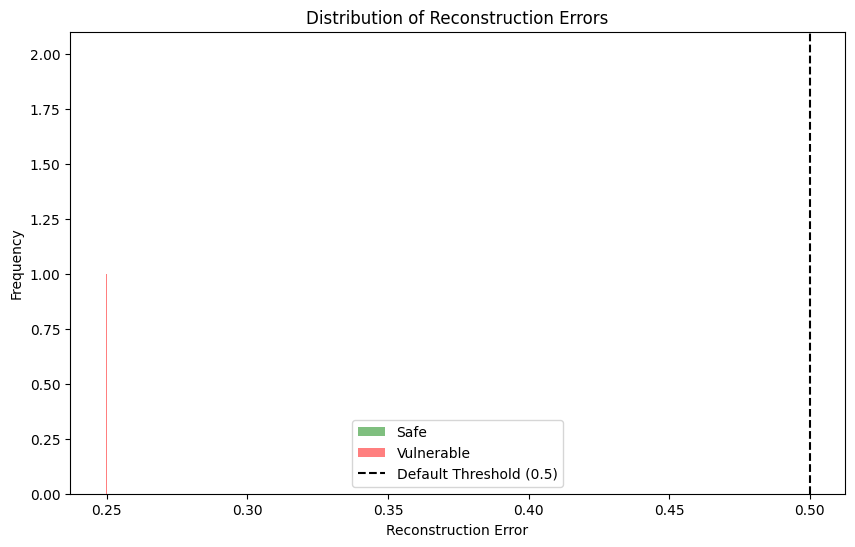

In [12]:
# Score distribution
safe_scores = y_scores[:len(safe_commits)]
vuln_scores = y_scores[len(safe_commits):]

plt.figure(figsize=(10, 6))
plt.hist(safe_scores, bins=20, alpha=0.5, label='Safe', color='green')
plt.hist(vuln_scores, bins=20, alpha=0.5, label='Vulnerable', color='red')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

In [13]:
# Find optimal threshold
best_threshold = None
best_f1 = 0

for threshold in np.arange(0.1, 1.0, 0.05):
    y_pred_temp = [1 if score > threshold else 0 for score in y_scores]
    report = classification_report(y_true, y_pred_temp, output_dict=True)
    f1 = report['weighted avg']['f1-score']
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nOptimal Threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_f1:.2%}")

# Re-evaluate with optimal threshold
y_pred_optimal = [1 if score > best_threshold else 0 for score in y_scores]
accuracy_optimal = accuracy_score(y_true, y_pred_optimal)
print(f"\nAccuracy with optimal threshold: {accuracy_optimal:.2%}")
print("\nClassification Report with optimal threshold:")
print(classification_report(y_true, y_pred_optimal, target_names=['Safe', 'Vulnerable']))


Optimal Threshold: 0.25
Best F1 Score: 43.57%

Accuracy with optimal threshold: 55.00%

Classification Report with optimal threshold:
              precision    recall  f1-score   support

        Safe       0.53      1.00      0.69        10
  Vulnerable       1.00      0.10      0.18        10

    accuracy                           0.55        20
   macro avg       0.76      0.55      0.44        20
weighted avg       0.76      0.55      0.44        20



/home/max/max-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/max/max-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/max/max-env/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/max/max-env/lib/python

In [14]:
# Example predictions
print("\n=== Example Predictions ===")
print("\nVulnerable Examples:")
for i, commit in enumerate(vulnerable_commits[:3]):
    is_vuln, score = predict_vulnerability(commit['message'], commit['func'], threshold=best_threshold)
    print(f"\n{i+1}. Message: {commit['message']}")
    print(f"   Score: {score:.4f}")
    print(f"   Predicted: {'Vulnerable' if is_vuln else 'Safe'}")
    print(f"   Correct: {'✓' if is_vuln else '✗'}")

print("\n\nSafe Examples:")
for i, commit in enumerate(safe_commits[:3]):
    is_vuln, score = predict_vulnerability(commit['message'], commit['func'], threshold=best_threshold)
    print(f"\n{i+1}. Message: {commit['message']}")
    print(f"   Score: {score:.4f}")
    print(f"   Predicted: {'Vulnerable' if is_vuln else 'Safe'}")
    print(f"   Correct: {'✓' if not is_vuln else '✗'}")


=== Example Predictions ===

Vulnerable Examples:

1. Message: fix buffer overflow in string copy
   Score: 0.2497
   Predicted: Safe
   Correct: ✗

2. Message: add user authentication
   Score: 0.2498
   Predicted: Safe
   Correct: ✗

3. Message: implement sql query function
   Score: 0.2497
   Predicted: Safe
   Correct: ✗


Safe Examples:

1. Message: fix buffer overflow in string copy
   Score: 0.2499
   Predicted: Safe
   Correct: ✓

2. Message: add user authentication
   Score: 0.2496
   Predicted: Safe
   Correct: ✓

3. Message: implement sql query function
   Score: 0.2499
   Predicted: Safe
   Correct: ✓
